In [1]:
import pandas as pd
import numpy as np
from ta import *
snp = pd.read_csv('S&P500_Data_Daily.csv')
dow = pd.read_csv('Dow_Jones_Data_Daily.csv')
nas = pd.read_csv('NASDAQ_Data_Daily.csv')

In [2]:
snp_df = add_all_ta_features(snp, "Open", "High", "Low", "Close", "Volume", fillna=True)
dow_df = add_all_ta_features(dow, "Open", "High", "Low", "Close", "Volume", fillna=True)
nas_df = add_all_ta_features(nas, "Open", "High", "Low", "Close", "Volume", fillna=True)

/opt/conda/lib/python3.6/site-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/opt/conda/lib/python3.6/site-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


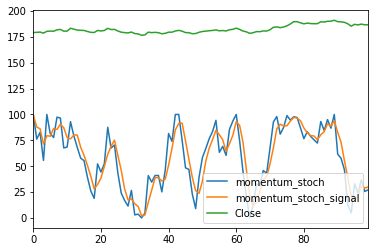

In [4]:
import matplotlib.pyplot as plt
snp_df[['momentum_stoch','momentum_stoch_signal', 'Close']].head(100).plot()
plt.show()

In [5]:
snp_df['Zero'] = 0
dow_df['Zero'] = 0
nas_df['Zero'] = 0

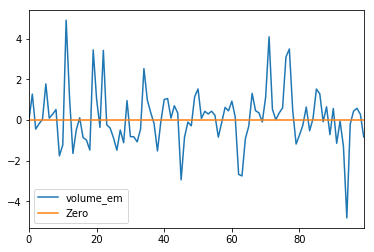

In [6]:
snp_df[['volume_em', 'Zero']].head(100).plot()
plt.show()

In [7]:
snp_df['rsi_high'] = 70
snp_df['rsi_low'] = 30
dow_df['rsi_high'] = 70
dow_df['rsi_low'] = 30
nas_df['rsi_high'] = 70
nas_df['rsi_low'] = 30

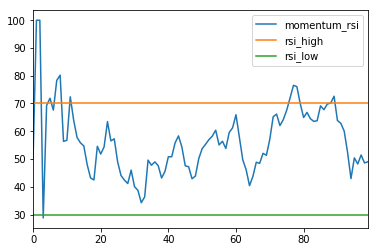

In [8]:
snp_df[['momentum_rsi', 'rsi_high', 'rsi_low']].head(100).plot()
plt.show()

In [9]:
snp_df['cmf_high'] = 0.05
snp_df['cmf_low'] = -0.05
dow_df['cmf_high'] = 0.05
dow_df['cmf_low'] = -0.05
nas_df['cmf_high'] = 0.05
nas_df['cmf_low'] = -0.05

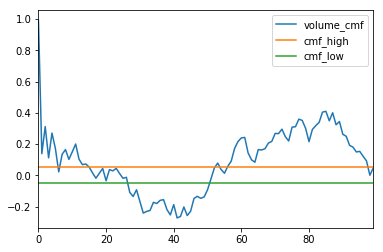

In [10]:
snp_df[['volume_cmf', 'cmf_high', 'cmf_low']].head(100).plot()
plt.show()

In [11]:
snp_df['momentum_rsi'].head(100)

0      50.000000
1     100.000000
2     100.000000
3      28.771850
4      69.289809
         ...    
95     50.404478
96     48.216458
97     51.442196
98     48.585288
99     49.014740
Name: momentum_rsi, Length: 100, dtype: float64

In [12]:
drop_labels = ['trend_visual_ichimoku_a','trend_visual_ichimoku_b', 
               'trend_aroon_up', 'trend_aroon_down','trend_aroon_ind', 
               'momentum_mfi', 'momentum_tsi',
               'momentum_uo', 
               'momentum_wr','momentum_ao', 
               'volatility_dch','volatility_dcl', 'volatility_dchi', 'volatility_dcli',
               'others_dr', 'others_dlr', 'others_cr',
               'volume_adi', 'volume_obv', 'volume_fi', 
               'volume_vpt', 'volume_nvi', 'volatility_atr',
               'trend_ema_fast','trend_ema_slow', 'trend_adx', 
               'trend_adx_pos', 'trend_adx_neg','trend_vortex_ind_pos', 
               'trend_vortex_ind_neg',
               'trend_trix', 'trend_mass_index', 'trend_cci', 
               'trend_dpo', 'trend_kst','trend_kst_sig', 'trend_kst_diff',
                'trend_vortex_ind_diff', 'trend_psar', 'trend_psar_up', 'trend_psar_down',
               'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_kama',
               'momentum_roc']
snp_df = snp_df.drop(drop_labels, axis = 1)
dow_df = dow_df.drop(drop_labels, axis = 1)
nas_df = nas_df.drop(drop_labels, axis = 1)

In [13]:
snp_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'volume_cmf', 'volume_em', 'volume_sma_em', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbm', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'momentum_rsi', 'momentum_stoch', 'momentum_stoch_signal', 'Zero',
       'rsi_high', 'rsi_low', 'cmf_high', 'cmf_low'],
      dtype='object')

In [14]:
def keltner_label(df):
    keltner_indicator_buy = df.apply(lambda row : row.Close > row.volatility_kch, axis = 1)
    keltner_indicator_buy = keltner_indicator_buy.map({True:1,False:0})
    keltner_indicator_sell = df.apply(lambda row : row.Close < row.volatility_kcl, axis = 1)
    keltner_indicator_sell = keltner_indicator_sell.map({True:-1,False:0})
    keltner_indicator = np.sum([keltner_indicator_buy, keltner_indicator_sell],axis=0)
    return keltner_indicator

In [15]:
snp_df['keltner_indicator'] = keltner_label(snp_df)
dow_df['keltner_indicator'] = keltner_label(dow_df)
nas_df['keltner_indicator'] = keltner_label(nas_df)

In [16]:
label_bbands = lambda x: x.volatility_bbhi + -1*x.volatility_bbli

In [17]:
snp_df['bbands_indicator'] = snp_df.apply(label_bbands, axis =1)
dow_df['bbands_indicator'] = dow_df.apply(label_bbands, axis =1)
nas_df['bbands_indicator'] = nas_df.apply(label_bbands, axis =1)

In [18]:
def cross_over(diff_column):
    df = pd.DataFrame()
    prev_diff = diff_column.shift(1)
    df['prev_diff'] = prev_diff
    df['diff_column'] = diff_column
    line = 0
    def f(row):
        if ((row.diff_column > line) & (row.prev_diff < line)): 
             return 1
        elif ((row.prev_diff > line) & (row.diff_column < line)):
            return -1
        else: 
            return 0
    cross = df.apply(f, axis = 1)
    return cross

def ichimoku_label(df):
    ichimoku_diff = df.apply(lambda x : x.trend_ichimoku_a - x.trend_ichimoku_b, axis = 1)
    return cross_over(ichimoku_diff)

def macd_label(df):
    return cross_over(df['trend_macd_diff'])

def ease_label(df):
    return cross_over(df['volume_em'])

def stochastic_label(df):
    stochastic_diff = df.apply(lambda x : x.momentum_stoch - x.momentum_stoch_signal, axis = 1)
    return cross_over(stochastic_diff)

In [19]:
snp_df['ichimoku_label'] = ichimoku_label(snp_df)
dow_df['ichimoku_label'] = ichimoku_label(dow_df)
nas_df['ichimoku_label'] = ichimoku_label(nas_df)

In [20]:
snp_df['macd_indicator'] = macd_label(snp_df)
dow_df['macd_indicator'] = macd_label(dow_df)
nas_df['macd_indicator'] = macd_label(nas_df)

In [21]:
snp_df['ease_label'] = ease_label(snp_df)
dow_df['ease_label'] = ease_label(dow_df)
nas_df['ease_label'] = ease_label(nas_df)

In [22]:
snp_df['stochastic_label'] = stochastic_label(snp_df)
dow_df['stochastic_label'] = stochastic_label(dow_df)
nas_df['stochastic_label'] = stochastic_label(nas_df)

In [23]:
def cross_over_rsi(diff_column):
    df = pd.DataFrame()
    prev_diff = diff_column.shift(1)
    df['prev_diff'] = prev_diff
    df['diff_column'] = diff_column
    high_line = 70
    low_line = 30
    def f(row):
        if ((row.diff_column < high_line) & (row.prev_diff > high_line)):
            return -1
        elif ((row.prev_diff < low_line) & (row.diff_column > low_line)):
            return 1
        else:
            return 0
    cross = df.apply(f, axis = 1)
    return cross

def rsi_label(df):
    return cross_over_rsi(df['momentum_rsi'])

In [24]:
snp_df['rsi_label'] = rsi_label(snp_df)
dow_df['rsi_label'] = rsi_label(dow_df)
nas_df['rsi_label'] = rsi_label(nas_df)

In [25]:
def cross_over_cmf(diff_column):
    df = pd.DataFrame()
    prev_diff = diff_column.shift(1)
    df['prev_diff'] = prev_diff
    df['diff_column'] = diff_column
    high_line = 0.05
    low_line = -0.05
    def f(row):
        if ((row.diff_column > high_line) & (row.prev_diff < high_line)):
            return 1
        elif ((row.prev_diff > low_line) & (row.diff_column < low_line)):
            return -1
        else:
            return 0
    cross = df.apply(f, axis = 1)
    return cross

def cmf_label(df):
    return cross_over_cmf(df['volume_cmf'])

In [26]:
snp_df['cmf_label'] = cmf_label(snp_df)
dow_df['cmf_label'] = cmf_label(dow_df)
nas_df['cmf_label'] = cmf_label(nas_df)

In [27]:
nas_labels = pd.read_csv('NASDAQ_daily_labels.csv', header=None)
nas_labels = nas_labels[0]
nas_labels = nas_labels.fillna(0)
nas_labels = nas_labels.map(lambda x: 0 if abs(x) < 0.5 else x)
nas_labels = nas_labels.map(lambda x: 1 if x > 0 else x)
nas_labels = nas_labels.map(lambda x: -1 if x < 0 else x)
nas_df['nas_labels'] = nas_labels

In [28]:
dow_labels = pd.read_csv('Dow_daily_labels.csv', header=None)
dow_labels = dow_labels[0]
dow_labels = dow_labels.fillna(0)
dow_labels = dow_labels.map(lambda x: 0 if abs(x) < 0.5 else x)
dow_labels = dow_labels.map(lambda x: 1 if x > 0 else x)
dow_labels = dow_labels.map(lambda x: -1 if x < 0 else x)
dow_df['dow_labels'] = dow_labels

In [30]:
snp_labels = pd.read_csv('SP_daily_labels.csv', header=None)
snp_labels = snp_labels[0]
snp_labels = snp_labels.fillna(0)
snp_labels = snp_labels.map(lambda x: 0 if abs(x) < 0.5 else x)
snp_labels = snp_labels.map(lambda x: 1 if x > 0 else x)
snp_labels = snp_labels.map(lambda x: -1 if x < 0 else x)
snp_df['snp_labels'] = snp_labels

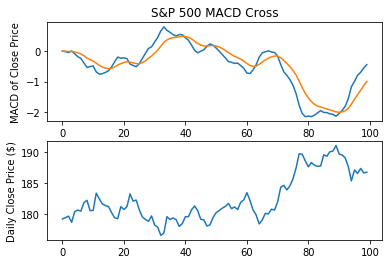

In [31]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.title('S&P 500 MACD Cross')
plt.plot(range(100), snp_df.trend_macd.head(100))
plt.plot(range(100), snp_df.trend_macd_signal.head(100))
plt.ylabel('MACD of Close Price')
plt.subplot(212)
plt.plot(range(100), snp_df.Close.head(100))
plt.ylabel('Daily Close Price ($)')
plt.savefig('MACD.png')
plt.show()

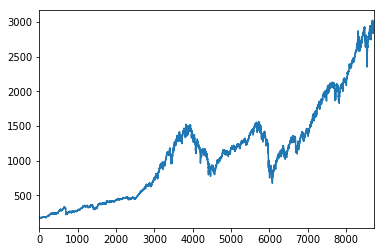

In [32]:
snp_df.Close.plot()

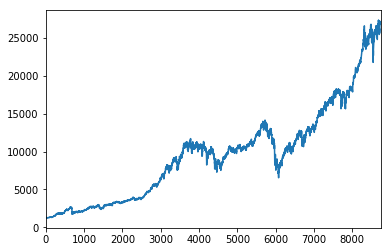

In [33]:
dow_df.Close.plot()

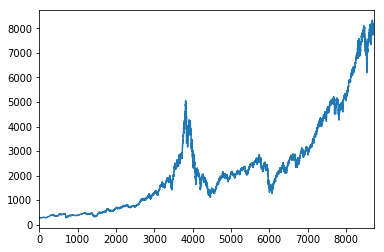

In [34]:
nas_df.Close.plot()

In [40]:
nas_df.to_csv("NASDAQ_technical_indicator_labels.csv")
dow_df.to_csv("Dow_technical_indicator_labels.csv")
snp_df.to_csv("S&P500_technical_indicator_labels.csv")